In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import img_as_float
from scipy.signal import convolve2d
from scipy.signal.windows import gaussian
from scipy.fft import fft2, fftshift, ifft2, ifftshift
from skimage.feature import corner_harris, corner_peaks
from skimage.transform import rotate

## 1. Inverse filtering

### Problem 1.1

In [2]:
def LSI_degradation(image, kernel, noise):
    image_degraded = convolve2d(image, kernel, mode="same", boundary="wrap") + noise
    return image_degraded

def gaussian_kernel(sigma):
    N = int(8*sigma)
    kernel = np.outer(gaussian(N, sigma), gaussian(N, sigma))
    kernel /= np.sum(kernel)  # normalize
    return kernel

def gaussian_noise(sigma, shape):
    noise = np.random.normal(0, sigma, shape)
    return noise

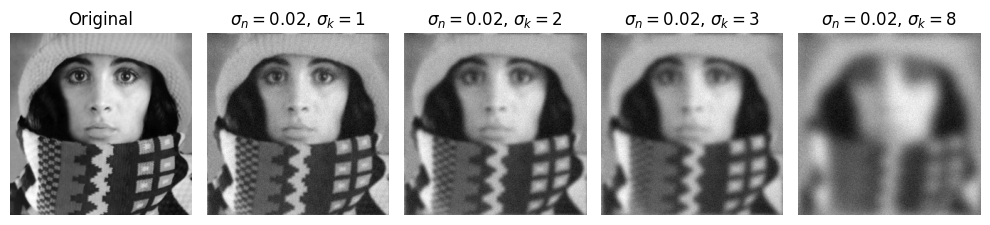

In [3]:
A = img_as_float(imread("trui.png"))

sigma_noise = 0.02
N = gaussian_noise(sigma_noise, A.shape)

sigma_kernel_array = np.array([1, 2, 3, 8])
K_array = []
for sig in sigma_kernel_array:
    K_array.append(gaussian_kernel(sig))

A_degraded_k = []
for k in K_array:
    A_degraded_k.append(LSI_degradation(A, k, N))

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(A, cmap="gray")
plt.axis("off")
plt.title("Original")

for i, A_deg in enumerate(A_degraded_k):
    plt.subplot(1, 5, i+2)
    plt.imshow(A_deg, cmap="gray")
    plt.axis("off")
    plt.title(fr"$\sigma_n={sigma_noise}$, $\sigma_k={sigma_kernel_array[i]}$")
    
plt.tight_layout()

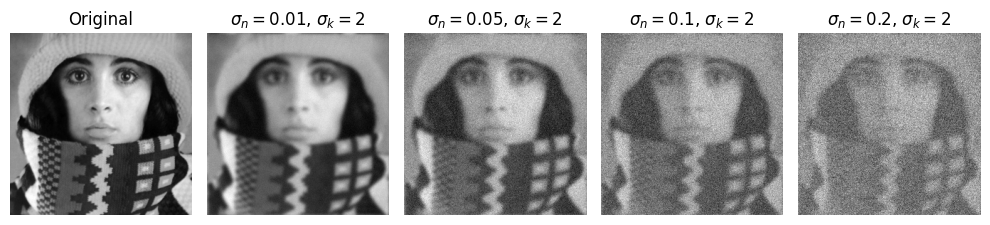

In [4]:
sigma_noise_array = np.array([0.01, 0.05, 0.1, 0.2])
N_array = []
for sig in sigma_noise_array:
    N_array.append(gaussian_noise(sig, A.shape))

sigma_kernel = 2
K = gaussian_kernel(sigma_kernel)

A_degraded_n = []
for n in N_array:
    A_degraded_n.append(LSI_degradation(A, K, n))

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(A, cmap="gray")
plt.axis("off")
plt.title("Original")

for i, A_deg in enumerate(A_degraded_n):
    plt.subplot(1, 5, i+2)
    plt.imshow(A_deg, cmap="gray")
    plt.axis("off")
    plt.title(fr"$\sigma_n={sigma_noise_array[i]}$, $\sigma_k={sigma_kernel}$")

plt.tight_layout()

### Problem 1.2

In [5]:
def PSF_fft(sigma, shape):
    PSF_1d = np.roll(gaussian(shape[0], sigma), int(shape[0] / 2))
    PSF_2d = np.outer(PSF_1d, PSF_1d)  # create kernel
    PSF_2d /= np.sum(PSF_2d)  # normalize

    return fftshift(fft2(PSF_2d))

def direct_inverse_filter(image_degraded, sigma_PSF):
    PSF_FT = PSF_fft(sigma_PSF, image_degraded.shape)  # create Fourier transformed kernel
    PSF_FT += 0.05 * np.max(PSF_FT)  # add small constant to avoid divide by zero
    image_degraded_FT = fftshift(fft2(image_degraded))  # Fourier transform image
    image_FT = image_degraded_FT / PSF_FT  # perform direct inverse filtering
    image = ifft2(ifftshift(image_FT))  # compute inverse Fourier transform
    
    return np.real(image)

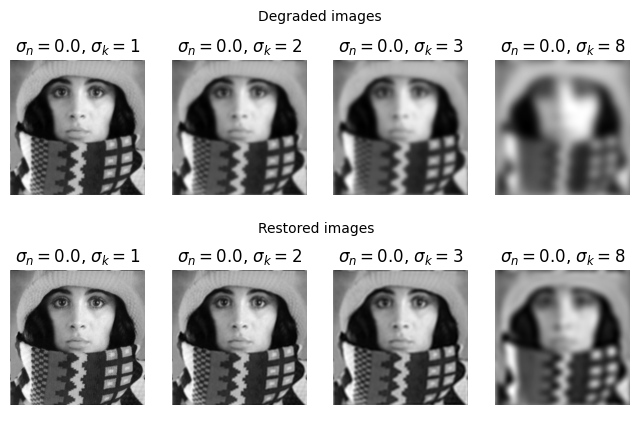

In [6]:
# Different kernels, no noise

sigma_no_noise = 0.0
no_noise = gaussian_noise(sigma_no_noise, A.shape)

sigma_kernel_array = np.array([1, 2, 3, 8])
K_no_noise_array = []
for sig in sigma_kernel_array:
    K_no_noise_array.append(gaussian_kernel(sig))

A_degraded_no_noise = []
for k in K_no_noise_array:
    A_degraded_no_noise.append(LSI_degradation(A, k, no_noise))

A_restored_no_noise = []
for i in range(len(sigma_kernel_array)):
    A_restored_no_noise.append(direct_inverse_filter(A_degraded_no_noise[i], sigma_kernel_array[i]))

plt.figure(figsize=(8, 5))

plt.text(0.4, 1.05, "Degraded images")
plt.text(0.4, 0.5, "Restored images")
plt.axis("off")

for i in range(len(sigma_kernel_array)):
    plt.subplot(2, 4, i+1)
    plt.imshow(A_degraded_no_noise[i], cmap="gray")
    plt.axis("off")
    plt.title(fr"$\sigma_n={sigma_no_noise}$, $\sigma_k={sigma_kernel_array[i]}$")

for i in range(len(sigma_kernel_array)):
    plt.subplot(2, 4, i+5)
    plt.imshow(A_restored_no_noise[i], cmap="gray")
    plt.axis("off")
    plt.title(fr"$\sigma_n={sigma_no_noise}$, $\sigma_k={sigma_kernel_array[i]}$")


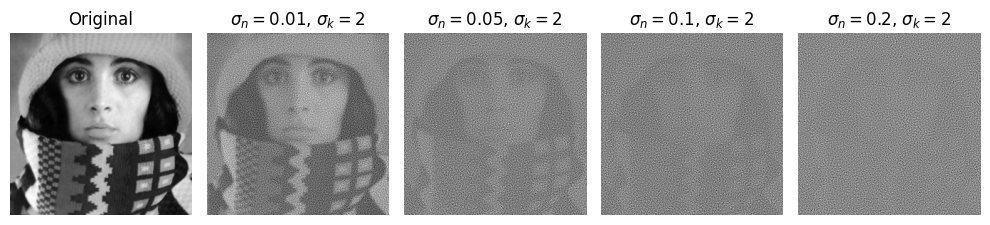

In [7]:
# Same kernel, different noise levels

A_restored_n = []
for i in range(len(sigma_noise_array)):
    A_restored_n.append(direct_inverse_filter(A_degraded_n[i], sigma_kernel))

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(A, cmap="gray")
plt.axis("off")
plt.title("Original")

for i in range(len(sigma_noise_array)):
    plt.subplot(1, 5, i+2)
    plt.imshow(A_restored_n[i], cmap="gray")
    plt.axis("off")
    plt.title(fr"$\sigma_n={sigma_noise_array[i]}$, $\sigma_k={sigma_kernel}$")
    
plt.tight_layout()

### Problem 1.3

In [8]:
def Wiener_filter(image_degraded, sigma_PSF, K):
    PSF_FT = PSF_fft(sigma_PSF, image_degraded.shape)  # create Fourier transformed kernel
    PSF_FT += 0.05 * np.max(PSF_FT)  # add small constant to avoid divide by zero
    image_degraded_FT = fftshift(fft2(image_degraded))  # Fourier transform image

    # perform Wiener filtering
    image_FT = (1 / PSF_FT * np.abs(PSF_FT)**2 / (np.abs(PSF_FT)**2 + K)) * image_degraded_FT  
    
    image = ifft2(ifftshift(image_FT))  # compute inverse Fourier transform

    return np.real(image)

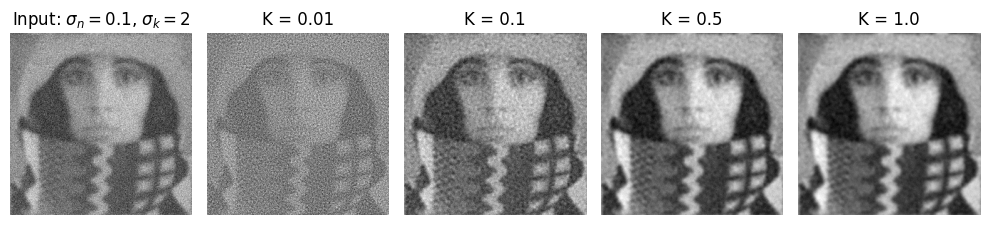

In [9]:
K_array = np.array([0.01, 0.1, 0.5, 1])

A_restored_const_noise_wiener = []
for i in range(len(sigma_noise_array)):
    A_restored_const_noise_wiener.append(Wiener_filter(A_degraded_n[-2], sigma_kernel, K=K_array[i]))

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(A_degraded_n[-2], cmap="gray")
plt.axis("off")
plt.title(rf"Input: $\sigma_n={sigma_noise_array[-2]}$, $\sigma_k={sigma_kernel}$")

for i in range(len(sigma_noise_array)):
    plt.subplot(1, 5, i+2)
    plt.imshow(A_restored_const_noise_wiener[i], cmap="gray")
    plt.axis("off")
    plt.title(fr"K = {K_array[i]}")
    
plt.tight_layout()

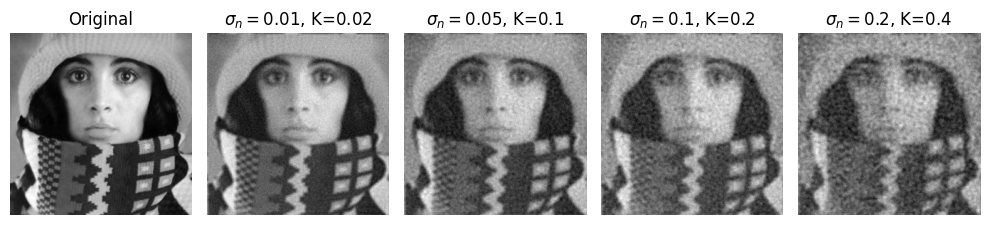

In [10]:
A_restored_n_wiener = []
for i in range(len(sigma_noise_array)):
    A_restored_n_wiener.append(Wiener_filter(A_degraded_n[i], sigma_kernel, K=sigma_noise_array[i]*2))

plt.figure(figsize=(10,4))
plt.subplot(1, 5, 1)
plt.imshow(A, cmap="gray")
plt.axis("off")
plt.title("Original")

for i in range(len(sigma_noise_array)):
    plt.subplot(1, 5, i+2)
    plt.imshow(A_restored_n_wiener[i], cmap="gray")
    plt.axis("off")
    plt.title(fr"$\sigma_n={sigma_noise_array[i]}$, K={sigma_noise_array[i]*2}")
    
plt.tight_layout()

## 2. Transformations on images - Translation

### Problem 2.4

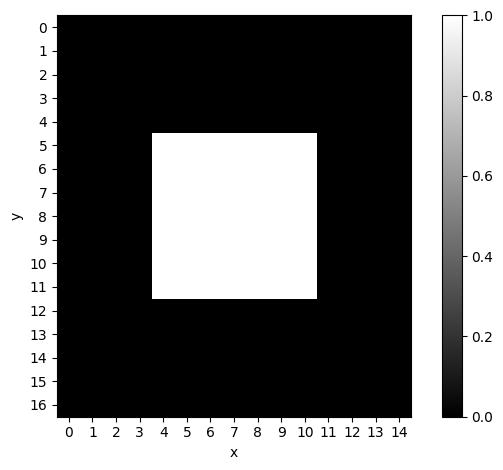

In [11]:
N_x = 15
N_y = 17


B = np.zeros((N_y, N_x))
B[5:-5, 4:-4] = 1

plt.imshow(B, cmap="gray")
plt.colorbar()
plt.xticks(np.arange(N_x), np.arange(N_x))
plt.yticks(np.arange(N_y), np.arange(N_y))
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()


### Problem 2.5

In [12]:
def translate(image, t_x, t_y):
    image_translated = np.copy(image)  # initialize

    for _ in range(np.abs(t_x)):  # translate t_x times along the x-axis (direction given by sign)
        kernel = np.zeros((3, 3))
        if t_x > 0:
            kernel[1, 2] = 1
        elif t_x < 0:
            kernel[1, 0] = 1
        image_translated = convolve2d(image_translated, kernel, mode="same", boundary="wrap")

    for _ in range(np.abs(t_y)):  # translate t_y times along the y-axis (direction given by sign)
        kernel = np.zeros((3, 3))
        if t_y > 0:
            kernel[2, 1] = 1
        elif t_y < 0:
            kernel[0, 1] = 1
        image_translated = convolve2d(image_translated, kernel, mode="same", boundary="wrap")
    
    return image_translated

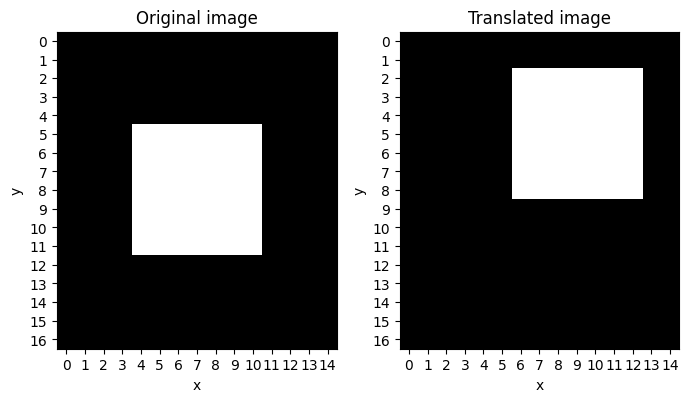

In [13]:
B_translated = translate(B, 2, -3)

plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
plt.imshow(B, cmap="gray")
plt.xticks(np.arange(N_x), np.arange(N_x))
plt.yticks(np.arange(N_y), np.arange(N_y))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(B_translated, cmap="gray")
plt.xticks(np.arange(N_x), np.arange(N_x))
plt.yticks(np.arange(N_y), np.arange(N_y))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Translated image")

plt.tight_layout()

### Problem 2.6

In [14]:
def transform_nearest_neighbor(image, trans_matrix):
    trans_matrix_inv = np.linalg.inv(trans_matrix)  # invert transformation matrix
    transformed_image = np.empty_like(image)  # initialize

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            old_coord = trans_matrix_inv @ np.array([i, j, 1], dtype=float)  # find coords in old image
            
            # enforce nearest neighbor interpolation
            old_i = int(np.round(old_coord[0]))
            old_j = int(np.round(old_coord[1]))

            # generate transformed image
            if old_i < 0 or old_j < 0 or old_i >= image.shape[0] or old_j >= image.shape[1]:
                transformed_image[i, j] = 0
            else:
                transformed_image[i, j] = image[old_i, old_j]
    
    return transformed_image

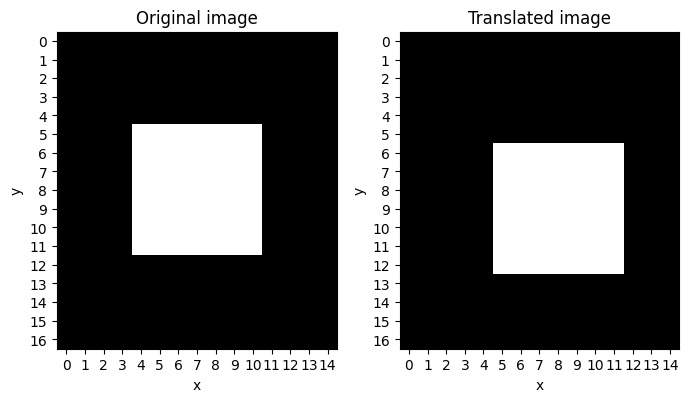

In [15]:
t_x = 0.6
t_y = 1.2

translate_matrix = np.array([[1, 0, t_x], [0, 1, t_y], [0, 0, 1]])

B_translated_nearest_neighbor = transform_nearest_neighbor(B, translate_matrix)

plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
plt.imshow(B, cmap="gray")
plt.xticks(np.arange(N_x), np.arange(N_x))
plt.yticks(np.arange(N_y), np.arange(N_y))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(B_translated_nearest_neighbor, cmap="gray")
plt.xticks(np.arange(N_x), np.arange(N_x))
plt.yticks(np.arange(N_y), np.arange(N_y))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Translated image")

plt.tight_layout()

### Problem 2.7

In [16]:
def translate_fourier(image, t_x, t_y):
    image_fft = fftshift(fft2(image))  # perform Fourier transform

    # make frequency grid
    u = np.arange(image.shape[1]) / image.shape[1] - 1/2
    v = np.arange(image.shape[0]) / image.shape[0] - 1/2
    U, V = np.meshgrid(u, v)

    # make filter kernel
    translate_kernel = np.exp(-1j*2*np.pi*U*t_x) * np.exp(-1j*2*np.pi*V*t_y)

    # apply filter
    image_translated_fft = translate_kernel * image_fft
    image_translated = np.real(ifft2(ifftshift(image_translated_fft)))

    return image_translated

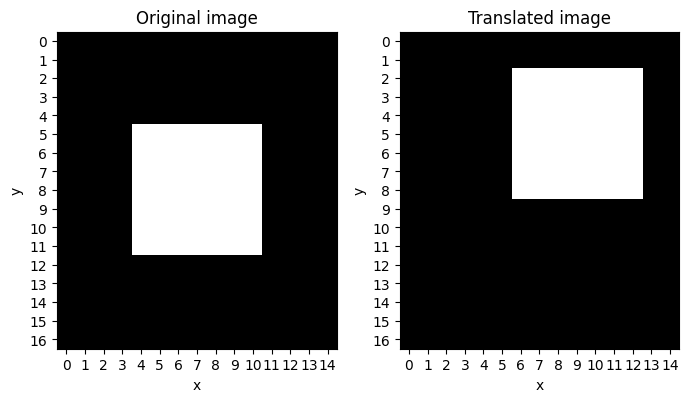

In [17]:
# Integer translation

t_x = 2
t_y = -3

B_translated_fourier = translate_fourier(B, t_x=t_x, t_y=t_y)

plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
plt.imshow(B, cmap="gray")
plt.xticks(np.arange(N_x), np.arange(N_x))
plt.yticks(np.arange(N_y), np.arange(N_y))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(B_translated_fourier, cmap="gray")
plt.xticks(np.arange(N_x), np.arange(N_x))
plt.yticks(np.arange(N_y), np.arange(N_y))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Translated image")

plt.tight_layout()

### Problem 2.8

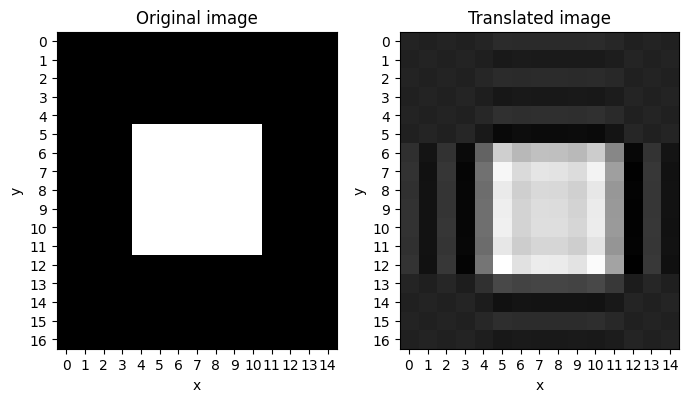

In [18]:
# Non-integer translation

t_x = 0.6
t_y = 1.2

B_translated_fourier = translate_fourier(B, t_x=t_x, t_y=t_y)

plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
plt.imshow(B, cmap="gray")
plt.xticks(np.arange(N_x), np.arange(N_x))
plt.yticks(np.arange(N_y), np.arange(N_y))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Original image")

plt.subplot(1, 2, 2)
plt.imshow(B_translated_fourier, cmap="gray")
plt.xticks(np.arange(N_x), np.arange(N_x))
plt.yticks(np.arange(N_y), np.arange(N_y))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Translated image")

plt.tight_layout()

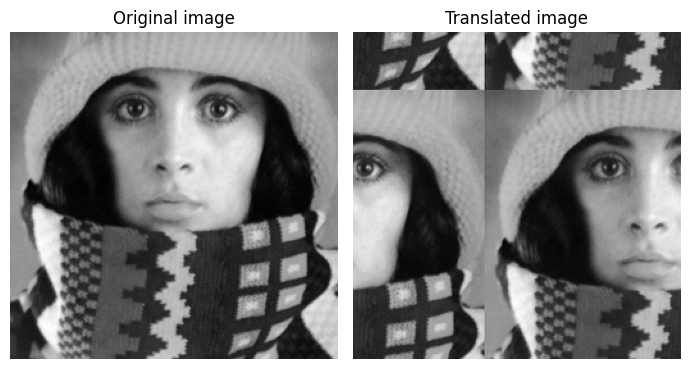

In [19]:
t_x = 102.6
t_y = 45.9

A_translated_fourier = translate_fourier(A, t_x=t_x, t_y=t_y)

plt.figure(figsize=(7, 5))

plt.subplot(1, 2, 1)
plt.imshow(A, cmap="gray")
plt.title("Original image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(A_translated_fourier, cmap="gray")
plt.title("Translated image")
plt.axis("off")

plt.tight_layout()

## 3. Feature detection and image transforms

### Problem 3.1

In [20]:
def find_corners(image, num_peaks=8, k=0.1, sigma=2):
    image_cut = image[:,int(image.shape[1]/2):]  # only consider rightmost half of image

    # find 8 strongest Harris corners
    feature_map = corner_harris(image_cut, method='k', k=k, sigma=sigma)
    corners = corner_peaks(feature_map, num_peaks=num_peaks)

    # initialize accepted corners
    x_accepted = []
    y_accepted = []

    # only accept corners in the indicated range
    for corner in corners:
        if (corner[1] + int(image.shape[1]/2) > image.shape[1] - int(image.shape[1]/4)) and \
              (corner[1] + int(image.shape[1]/2) < image.shape[1] - int(image.shape[1]/20)):
            x_accepted.append(corner[1] + int(image.shape[1]/2))
            y_accepted.append(corner[0])
    
    # print warning if more or less than two points are accepted
    if len(x_accepted) != 2:
        print("Wrong number of corners accepted!")

    return x_accepted, y_accepted, corners

(-0.5, 503.5, 780.5, -0.5)

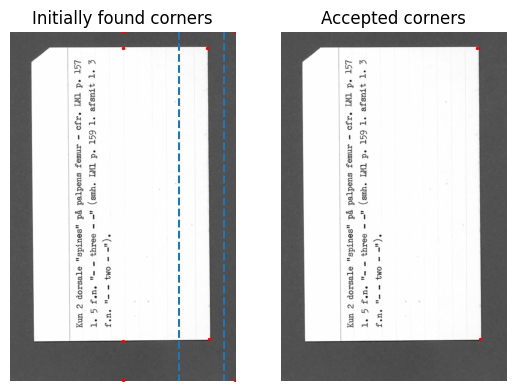

In [21]:
C = imread("textlabel_gray_small.png")

accepted_x, accepted_y, corners = find_corners(C)
corners[:,1] += int(C.shape[1]/2)

plt.subplot(1, 2, 1)
plt.imshow(C, cmap="gray")
plt.scatter(corners[:,1], corners[:,0], s=2, c="red")
plt.vlines(C.shape[1] - int(C.shape[1]/4), 0+1, C.shape[0]-1, linestyles="dashed")
plt.vlines(C.shape[1] - int(C.shape[1]/20), 0+1, C.shape[0]-1, linestyles="dashed")
plt.title("Initially found corners")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(C, cmap="gray")
plt.scatter(accepted_x, accepted_y, s=2, c="red")
plt.title("Accepted corners")
plt.axis("off")

In [22]:
angle_rad = np.arctan(np.abs(accepted_x[0]-accepted_x[1]) / np.abs(accepted_y[0]-accepted_y[1])) + np.pi/2
angle_degree = angle_rad * 180/np.pi
print(f"Rotation angle (counter-clockwise): {-angle_degree} degrees")

Rotation angle (counter-clockwise): -90.52805674890017 degrees


(-0.5, 785.5, 510.5, -0.5)

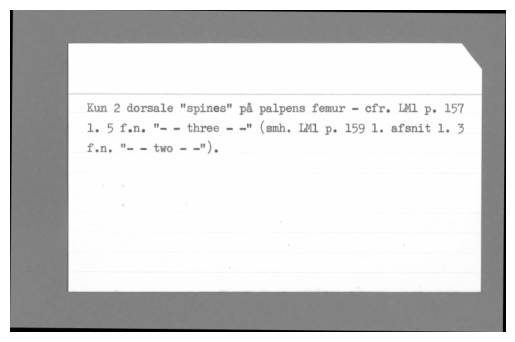

In [23]:
C_rotated = rotate(C, -angle_degree, resize=True)
plt.imshow(C_rotated, cmap="gray")
plt.axis("off")